In [11]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add parent directory to path
import pandas as pd

In [12]:
# Elimina los directorios que contienen 'tclean' en su nombre
import shutil

data_folder = "../data/processed"
for i,file_folder in enumerate(os.listdir(data_folder)):
    if file_folder == '.DS_Store':
        continue
    image_folder = os.path.join(data_folder, file_folder)
    list_dir = os.listdir(image_folder)

    for d in list_dir:
        if 'tclean' in d:
            shutil.rmtree(os.path.join(image_folder, d))

In [13]:
from src.preprocess.imager import Imager
from src.preprocess.image_quality_metrics import ImageQualityMetrics
import pandas as pd

df_image = pd.DataFrame(columns=['image_name','niter','snr','ssim','psnr'])
df_model = pd.DataFrame(columns=['image_name','niter','snr','ssim','psnr'])

data_folder = "../data/processed"
for i,file_folder in enumerate(os.listdir(data_folder)):
    if i>=10:
        break
    print(f'Processing folder {i+1}/{len(os.listdir(data_folder))}')
    image_folder = os.path.join(data_folder, file_folder)
    ms_file = os.listdir(os.path.join(image_folder,'ms'))[0]
    ms_path = os.path.join(image_folder, 'ms', ms_file)

    niter_image = []
    snr_image = []
    ssim_image = []
    psnr_image = []

    niter_model = []
    snr_model = []
    ssim_model = []
    psnr_model = []

    n_power = 20
    for power in range(n_power):
        imager = Imager(vis = ms_path, output_path=image_folder)
        niter = 2**(power)
        tclean_config = {
            'imsize': 256,
            'cell': '0.04arcsec',
            'niter': niter,
            'weighting': 'natural',
        }
        imager.tclean(config=tclean_config)

        reference_folder = os.path.join(image_folder, 'groundtruth')
        reference_image = os.listdir(reference_folder)[0]
        reference_path = os.path.join(reference_folder, reference_image)

        model_path = os.path.join(image_folder, f'tclean_{niter}', f'tclean_{niter}.model')
        image_path = os.path.join(image_folder, f'tclean_{niter}', f'tclean_{niter}.image')

        iqm_model = ImageQualityMetrics(image_path=model_path, reference_path=reference_path)
        niter_model.append(niter)
        snr_model.append(iqm_model.calculate_snr())
        ssim_model.append(iqm_model.calculate_ssim())
        psnr_model.append(iqm_model.calculate_psnr())

        iqm_image = ImageQualityMetrics(image_path=image_path, reference_path=reference_path)
        niter_image.append(niter)
        snr_image.append(iqm_image.calculate_snr())
        ssim_image.append(iqm_image.calculate_ssim())
        psnr_image.append(iqm_image.calculate_psnr())

    df_image = pd.concat([df_image, pd.DataFrame({
        'image_name': file_folder,
        'niter': niter_image,
        'snr': snr_image,
        'ssim': ssim_image,
        'psnr': psnr_image
    })], ignore_index=True)
    df_model = pd.concat([df_model, pd.DataFrame({
        'image_name': file_folder,
        'niter': niter_model,
        'snr': snr_model,
        'ssim': ssim_model,
        'psnr': psnr_model
    })], ignore_index=True)

Processing folder 1/1002


/var/folders/jd/f_tz2t411v14427qk6ggvkfw0000gn/T/ipykernel_92118/3564225618.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_image = pd.concat([df_image, pd.DataFrame({
/var/folders/jd/f_tz2t411v14427qk6ggvkfw0000gn/T/ipykernel_92118/3564225618.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_model = pd.concat([df_model, pd.DataFrame({


Processing folder 2/1002
Processing folder 3/1002
Processing folder 4/1002
Processing folder 5/1002
Processing folder 6/1002
Processing folder 7/1002
Processing folder 8/1002
Processing folder 9/1002
Processing folder 10/1002


In [14]:
df_image.to_csv('tclean_iter_metrics_model.csv', index=False)
df_model.to_csv('tclean_iter_metrics_image.csv', index=False)

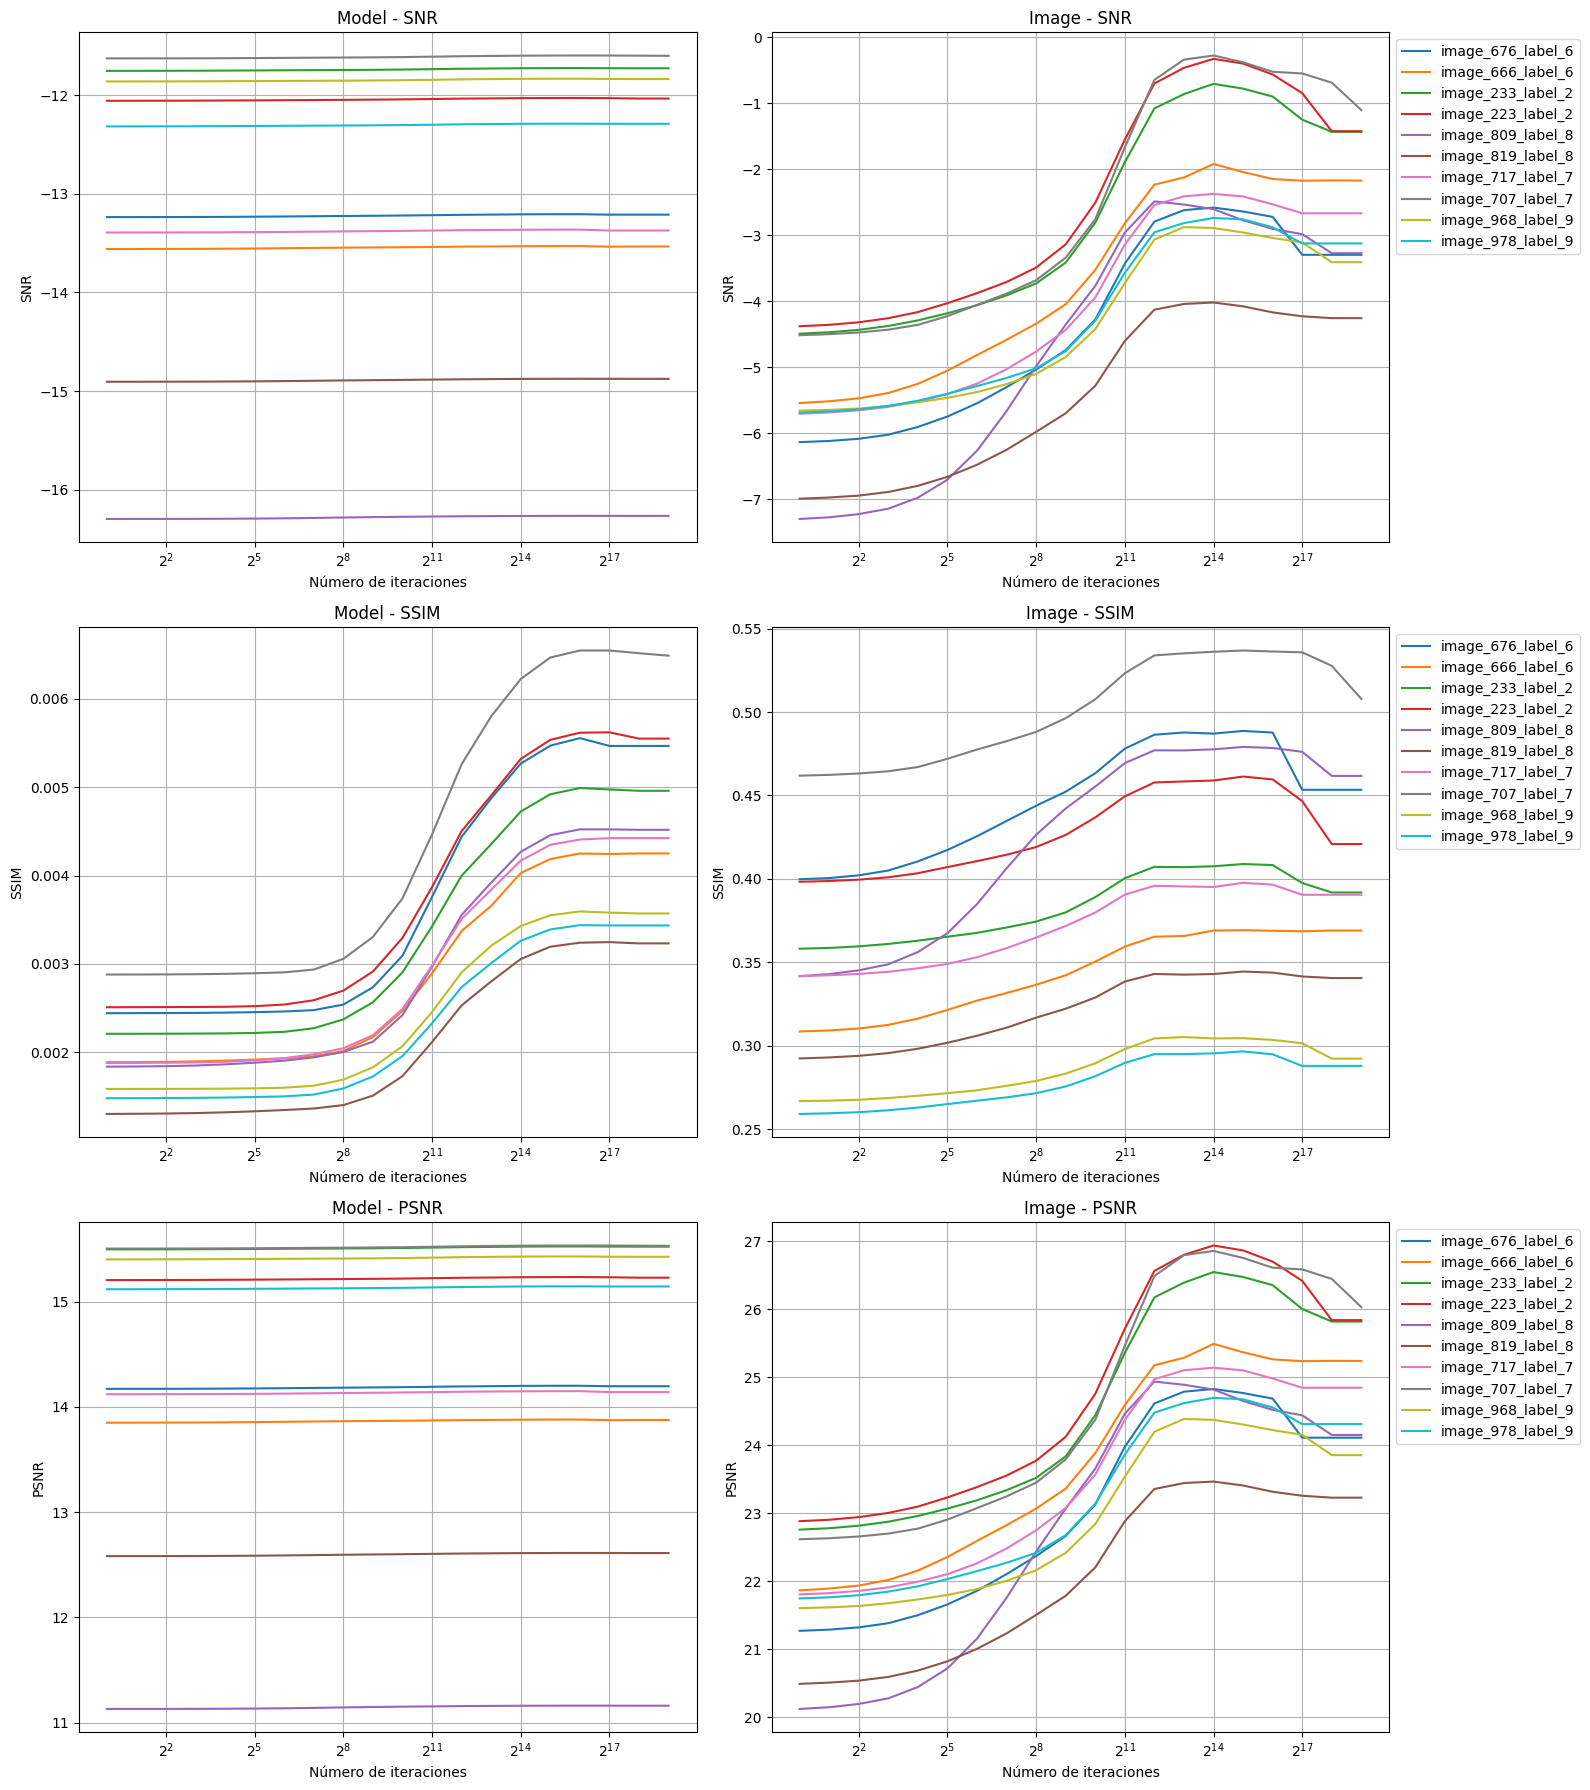

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df_image = pd.read_csv('tclean_iter_metrics_model.csv')
df_model = pd.read_csv('tclean_iter_metrics_image.csv')

df_image['niter'] = df_image['niter'].astype(int)
df_model['niter'] = df_model['niter'].astype(int)

image_names = df_image['image_name'].unique()

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
metrics = ['snr', 'ssim', 'psnr']

for row, metric in enumerate(metrics):
    # Left: model
    ax_model = axes[row, 0]
    for image_folder in image_names:
        model_df = df_model[df_model['image_name'] == image_folder]
        ax_model.plot(model_df['niter'], model_df[metric], label=image_folder)
    ax_model.set_title(f'Model - {metric.upper()}')
    ax_model.set_xlabel('Número de iteraciones')
    ax_model.set_ylabel(metric.upper())
    ax_model.set_xscale('log', base=2)
    ax_model.grid(True)

    # Right: image
    ax_image = axes[row, 1]
    for image_folder in image_names:
        image_df = df_image[df_image['image_name'] == image_folder]
        ax_image.plot(image_df['niter'], image_df[metric], label=image_folder)
    ax_image.set_title(f'Image - {metric.upper()}')
    ax_image.set_xlabel('Número de iteraciones')
    ax_image.set_ylabel(metric.upper())
    ax_image.set_xscale('log', base=2)
    ax_image.grid(True)
    ax_image.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()